# ELN Model Result Comparison -- Bar Plot and Precision-Recall Curve

## Outline

The **MLAging - preprocessing** workflow consists of  sections:

`00 preprocessing.R` Data preprocessing and preparation in Seurat.

`011 Preprocessing HEG ELN Tuning` ELN model tunning using highly expressed genes (HEGs) and hyperparameter selection using `GridSearchCV`.

`012 Preprocessing HVG ELN Tuning` ELN model tunning using highly variable genes (HVGs) and hyperparameter selection using `GridSearchCV`.
 
`02 Preprocessing ELN Result 10x` Run the best ELN model over 10 random seeds.

`03 Preprocessing ELN Result Viz` Result visulization -- **this notebook**:
1. [Performance (AUPRC) bar plots](#1.-barplot)
2. [Precision-Recall curve](#2.-prcurve)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from statistics import mean, stdev
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from src.data_processing import *
from src.grid_search import *

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

import warnings
warnings.filterwarnings('ignore')

In [2]:
pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True,
                            needs_proba=True)

## 1. Performance (AUPRC) bar plots <a name="1.-barplot"></a>

In [3]:
files = os.listdir('../results/preprocess_best/')
scores_l = []
for file in files:
    if file.endswith('_eln_model_test_scores.save'):
        scores_l.append(file.split('_eln_model_test_scores.save')[0])
scores_l

['hvg_lognorm_std',
 'hvg_lognorm_std_int',
 'heg_lognorm_std_int',
 'heg_lognorm_std',
 'hvg_lognorm_std_int_bin',
 'heg_lognorm',
 'hvg_lognorm',
 'heg_lognorm_std_int_bin']

In [4]:
for i in scores_l:
    file = open('../results/preprocess_best/' + i + '_eln_model_test_scores.save', 'rb')
    locals()[i]  = pickle.load(file)
    file.close()

In [5]:
df_bar = pd.DataFrame(columns=['Preprocessing', 'Features', 'AUPRC'])
for i in scores_l:
    df_new = pd.DataFrame(columns=['Preprocessing', 'AUPRC'], index=range(0, 10))
    identities = i.split('_',2)

    df_new['Features'] = identities[0]
    df_new['Preprocessing'] = identities[-1]
    df_new['AUPRC'] = locals()[i]
    df_bar = df_bar.append(df_new)

In [6]:
df_bar

,Preprocessing,Features,AUPRC
0,std,hvg,0.728521
1,std,hvg,0.728522
2,std,hvg,0.728521
3,std,hvg,0.728521
4,std,hvg,0.728521
...,...,...,...
5,std_int_bin,heg,0.607951
6,std_int_bin,heg,0.607951
7,std_int_bin,heg,0.607951
8,std_int_bin,heg,0.607951


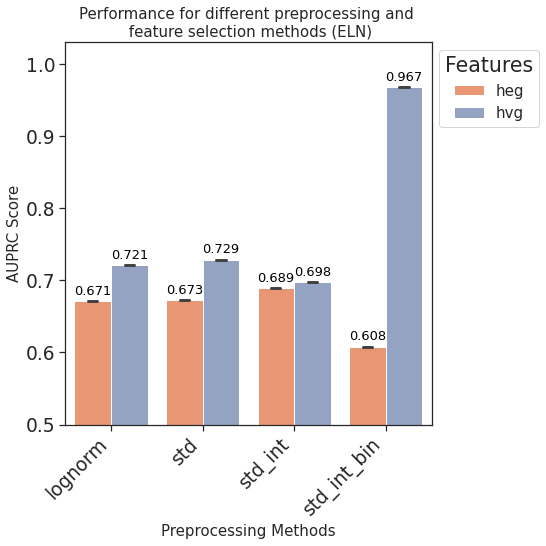

In [7]:
plt.figure(figsize=(8,8))
sns.set(font_scale=1.7, style='ticks')

ax = sns.barplot(data=df_bar, x='Preprocessing', y='AUPRC', hue='Features',  capsize=.1,
                order=['lognorm', 'std', 'std_int', 'std_int_bin'], hue_order=["heg", "hvg"],
                palette=[sns.color_palette("Set2")[1], sns.color_palette("Set2")[2]])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height()+0.005, '{0:.3f}'.format(p.get_height()), 
        fontsize=13, color='black', ha='center', va='bottom')
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right')

plt.title('Performance for different preprocessing and \n feature selection methods (ELN)', fontsize=15)
plt.xlabel("Preprocessing Methods", fontsize=15)
plt.ylabel("AUPRC Score", fontsize=15)

plt.ylim(0.5, 1.03)
plt.legend(title='Features', bbox_to_anchor=(1, 1), fontsize=15)
plt.tight_layout()
# plt.savefig('../figures/2d_feature_prepro_bar_AUPRC.pdf')
plt.show()

## 2. Precision-Recall Curve <a name="2.-prcurve"></a>

In [8]:
test_sets = []
for i in scores_l:
    test_set = i
    file = open('../results/preprocess_best/' + i + '_eln_model_test_sets.save', 'rb')
    all_10_files = pickle.load(file)
    test_sets.append(all_10_files[0])
    file.close()

In [9]:
models = []
for i in scores_l:
    model= i
    file = open('../results/preprocess_best/' + i + '_eln_model_test_models.save', 'rb')
    all_10_files = pickle.load(file)
    models.append(all_10_files[0])
    file.close()

In [10]:
# for ML models
def calculate_MLPR(ML_model, test_X, test_y):
    y_test_prob = ML_model.predict_proba(test_X)[:,1]
    precision, recall, thresholds = precision_recall_curve(test_y, y_test_prob)
    return recall, precision, auc(recall, precision)

In [11]:
blues = sns.color_palette("Blues", 4)
oranges = sns.color_palette("Oranges", 4)

In [12]:
scores_l_ordered = ['heg_lognorm',
                    'heg_lognorm_std',
                    'heg_lognorm_std_int',
                    'heg_lognorm_std_int_bin',
                    'hvg_lognorm',
                    'hvg_lognorm_std',
                    'hvg_lognorm_std_int',
                    'hvg_lognorm_std_int_bin']

In [13]:
color_lists = oranges + blues
oranges.sort(reverse=True)
new_list = [i.replace('_lognorm', '') for s in scores_l]
print(new_list)

['heg_std_int_bin', 'heg_std_int_bin', 'heg_std_int_bin', 'heg_std_int_bin', 'heg_std_int_bin', 'heg_std_int_bin', 'heg_std_int_bin', 'heg_std_int_bin']


In [14]:
# calculate the baseline, the major category is aged
test_X, test_y = test_sets[0]
a = models[0].predict_proba(test_X)[:,1]
a = a *0 + 1
precision, recall, thresholds = precision_recall_curve(test_y, a)
baseline =  auc(recall, precision)
baseline

0.8286780851998243

heg
heg_std
heg_std_int
heg_std_int_bin
hvg
hvg_std
hvg_std_int
hvg_std_int_bin


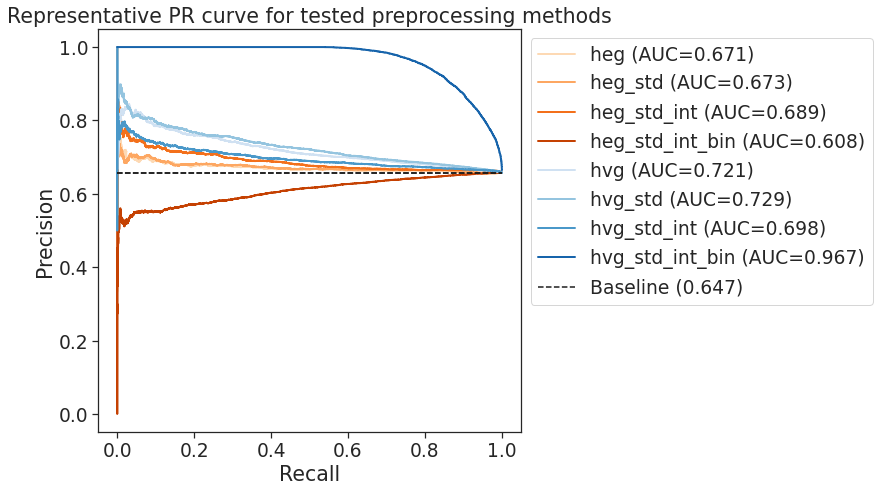

In [15]:
plt.figure(figsize=(12,7))
sns.set(font_scale=1.7, style='ticks')
color_lists = oranges + blues
for i in scores_l_ordered:
    idx = scores_l_ordered.index(i)
    
    idx_test = scores_l.index(i)
    test_X, test_y = test_sets[idx_test]
    recall, precision, auprc = calculate_MLPR(models[idx_test], test_X, test_y)
    name = i.replace('_lognorm', '')
    print(name)
    plt.plot(recall, precision, 'b', 
            label=f'{name} (AUC={round(auprc, 3)})',
            color=color_lists[idx],
            lw=2)
    
    
baseline = max(test_y.value_counts())/test_y.shape[0]
plt.plot([0, 1], [baseline, baseline], 'k--' , label='Baseline (0.647)')

plt.plot([0, 1], [baseline, baseline], 'k--' )
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.rcParams.update({'font.size': 12})   
plt.title('Representative PR curve for tested preprocessing methods')
    
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
#plt.savefig('../figures/2c_pr_curve.pdf')